In [1]:
# !pip install -q git+https://github.com/huggingface/transformers

In [2]:
import torch
import os
import io
import time
import glob
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from utils import *
%matplotlib inline
# Import sam vit pretrained model
from transformers import SamModel, SamProcessor

2023-12-13 10:48:37.914267: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
files_grabbed = []
files_info = []
path_check_include = ''

path_ign = os.getcwd() + '/data'
files_grabbed = glob.glob(os.path.join(path_ign, '*.jp2'))
files_info = glob.glob(os.path.join(path_ign, '*.tab'))
files_grabbed = [x for x in files_grabbed if path_check_include in x]
files_info = [x for x in files_info if path_check_include in x]

print("- nombre d'images:", len(files_grabbed), ', nb files info coord:', len(files_info))

- nombre d'images: 191 , nb files info coord: 191


In [4]:
def read_one(fname):
    img = cv2.imread(fname)      
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    return img
fname = files_grabbed[0]
print(fname)
ts = time.time()
img = read_one(fname)
print(time.time() - ts)

/home/coartix/S9-EPITA/ALEIA/General/PoolFinder/data/84-2018-0870-6310-LA93-0M50-IRC-E080.jp2
4.927130699157715


#### Preprocess

In [5]:
def preprocess_image(img):
    # Read the image
    #img = cv2.imread(image_path)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Normalize the image
    img_normalized = img / 255.0

    # Convert back to 8-bit format
    img_normalized = (img_normalized * 255).astype(np.uint8)

    # Enhance contrast - convert to YUV and equalize the Y channel
    img_yuv = cv2.cvtColor(img_normalized, cv2.COLOR_RGB2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    img_contrast_enhanced = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

    # Correct reddish tint - scale down the red channel
    # red_scale_factor = 0.75
    # img_contrast_enhanced[:, :, 0] = np.clip(img_contrast_enhanced[:, :, 0] * red_scale_factor, 0, 255).astype(np.uint8)

    # Identify blue regions
    # hsv_img = cv2.cvtColor(img_contrast_enhanced, cv2.COLOR_RGB2HSV)
    # Define range for blue color
    lower_blue = np.array([100, 150, 0])
    upper_blue = np.array([140, 255, 255])
    blue_mask = cv2.inRange(img_contrast_enhanced, lower_blue, upper_blue)

    # Dilate the blue regions to make them larger
    kernel = np.ones((5, 5), np.uint8)  # Kernel size can be adjusted
    blue_mask_dilated = cv2.dilate(blue_mask, kernel, iterations=1)

    # Apply the dilated mask to the image to enhance blue regions
    img_blue_enhanced = img_contrast_enhanced.copy()
    img_blue_enhanced[blue_mask_dilated > 0] = img_contrast_enhanced[blue_mask_dilated > 0] * 1.1
    img_blue_enhanced = np.clip(img_blue_enhanced, 0, 255)

    return img_blue_enhanced

##### Change to hsv

In [6]:
'''img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()'''

'img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)\nplt.figure(figsize=(10,10))\nplt.imshow(img)\nplt.show()'

In [7]:
def split_image(img, nb_split):
    img_split = []
    h, w, c = img.shape
    for i in range(nb_split):
        for j in range(nb_split):
            img_split.append(img[i*h//nb_split:(i+1)*h//nb_split, j*w//nb_split:(j+1)*w//nb_split, :])
    return img_split

img_split = split_image(img, 256)
print(len(img_split))

65536


Loading model

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

Device: cuda


/home/coartix/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_hip.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [9]:
img1 = img_split[2053]
img1 = preprocess_image(img1)
img1 = Image.fromarray(img1)

inputs = processor(img1, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

mask = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
)
scores = outputs.iou_scores

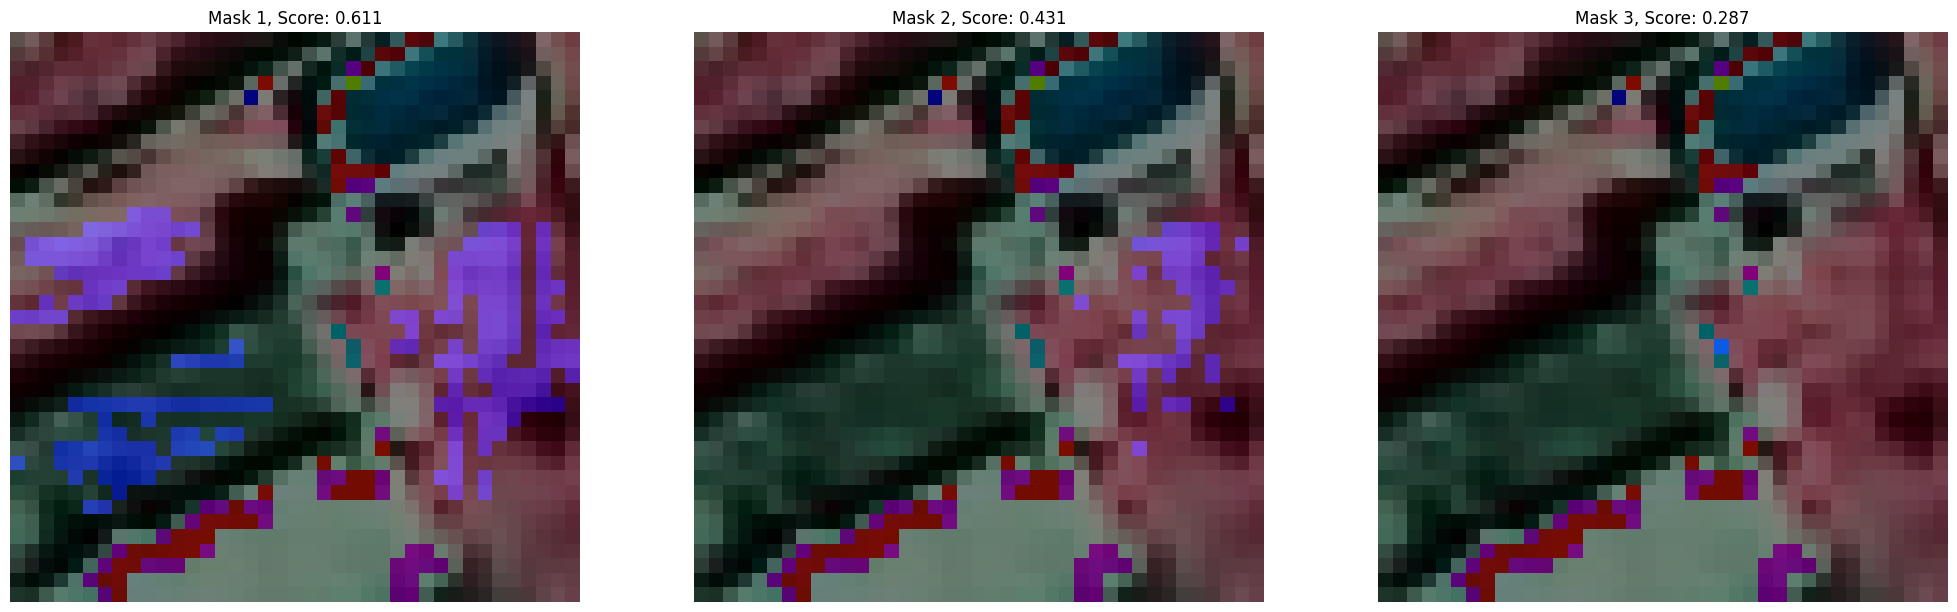

In [10]:
show_masks_on_image(img1, mask[0], scores)

In [12]:
print(len(mask))

1
